In [1]:
%matplotlib inline
import os
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
import urllib.request

# import Well Location(geospatial info) csv files as Pandas dataframes

In [2]:
# Specify the columns you want to read
columns_to_read = ['WCRNUMBER', 'DECIMALLATITUDE', 'DECIMALLONGITUDE']

try:
    # Read CSV file with specified columns
    df1 = pd.read_csv("wellcompletionreports.csv", usecols=columns_to_read)
    
    # Display the first few rows to verify
    print(df1.head())
except FileNotFoundError:
    print("File not found.")
except Exception as e:
    print(f"Error: {e}")

        WCRNUMBER DECIMALLATITUDE DECIMALLONGITUDE
0  WCR2005-016846         37.6724         -121.724
1  WCR2006-007057         37.5258          -122.03
2  WCR2006-000009             NaN              NaN
3  WCR2006-002311             NaN              NaN
4  WCR2006-002049             NaN              NaN


C:\Users\betebari\AppData\Local\Temp\ipykernel_14416\3724982913.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("wellcompletionreports.csv", usecols=columns_to_read)


## Convert '/' character to decimal character
# i.e. 
# 37/41/13.06/  
# to 37+41 
# divide by /60 
# +
# 13.06 
# divide by 3600

In [3]:
def convert_latitude(lat):
    if isinstance(lat, str) and '/' in lat:
        lat_parts = lat.split('/')[:-1]  # Exclude the last element
        try:
            degrees, minutes, seconds = map(float, lat_parts)
            decimal_lat = degrees + (minutes / 60) + (seconds / 3600)
            return decimal_lat
        except ValueError:
            return None
    else:
        try:
            return float(lat)
        except (ValueError, TypeError):
            return None

def convert_longitude(lon):
    if isinstance(lon, str) and '/' in lon:
        lon_parts = lon.split('/')[:-1]  # Exclude the last element
        try:
            degrees, minutes, seconds = map(float, lon_parts)
            decimal_lon = degrees + (minutes / 60) + (seconds / 3600)
            return decimal_lon
        except ValueError:
            return None
    else:
        try:
            return float(lon)
        except (ValueError, TypeError):
            return None

In [4]:
df1['Decimal_Latitude'] = df1['DECIMALLATITUDE'].apply(convert_latitude)
df1['Decimal_Longitude'] = df1['DECIMALLONGITUDE'].apply(convert_longitude)

In [5]:
df1 = df1.dropna(subset=['DECIMALLONGITUDE','DECIMALLATITUDE'])

In [6]:
print(df1)

              WCRNUMBER DECIMALLATITUDE DECIMALLONGITUDE  Decimal_Latitude  \
0        WCR2005-016846         37.6724         -121.724         37.672400   
1        WCR2006-007057         37.5258          -122.03         37.525800   
5        WCR2022-006791         37.7705         -122.235         37.770500   
6        WCR2022-006853         37.7708         -122.236         37.770800   
7        WCR2022-009252         37.8632         -122.269         37.863200   
...                 ...             ...              ...               ...   
1077126  WCR2016-010959       38.833611      -121.254444         38.833611   
1077127  WCR2017-009515       37.338851      -120.448137         37.338851   
1077128  WCR2015-007327       38.044167      -121.236667         38.044167   
1077152  WCR2015-012485       38.179167      -121.070278         38.179167   
1077167  WCR2015-010692       37.768014       -121.30825         37.768014   

         Decimal_Longitude  
0              -121.724000  
1    

In [7]:
df1 = df1.dropna(how='all')

In [8]:
# df1.to_csv('UPDATED_wellcompletionreports.csv')

#only the Central Valley Stations are needed

In [9]:
aquifer_boundary = gpd.read_file('central_val_buf_5mil_wgs84.shp')

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

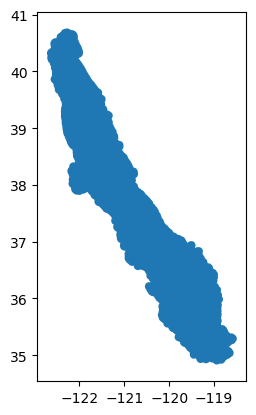

In [10]:
aquifer_boundary.plot()
aquifer_boundary.crs

In [11]:
# WCR's locations into a geo-dataframe
WCR_CA = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.Decimal_Longitude, df1.Decimal_Latitude))

In [12]:
# WCR's locations ESPG
WCR_CA.crs = {'init': 'epsg:4326'}

C:\Users\betebari\AppData\Local\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
# WCR's locations 2 shapefile
WCR_CA.to_file('WCR_CA.shp', driver='ESRI Shapefile')
WCR_CA.crs

C:\Users\betebari\AppData\Local\Temp\ipykernel_14416\1802922466.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  WCR_CA.to_file('WCR_CA.shp', driver='ESRI Shapefile')


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
WCR_CA = gpd.read_file('WCR_CA.shp')

In [15]:
klip = gpd.clip(WCR_CA, aquifer_boundary)
klip.shape

(341535, 6)

In [16]:
klip.crs
klip.to_file('klip.shp', driver='ESRI Shapefile')

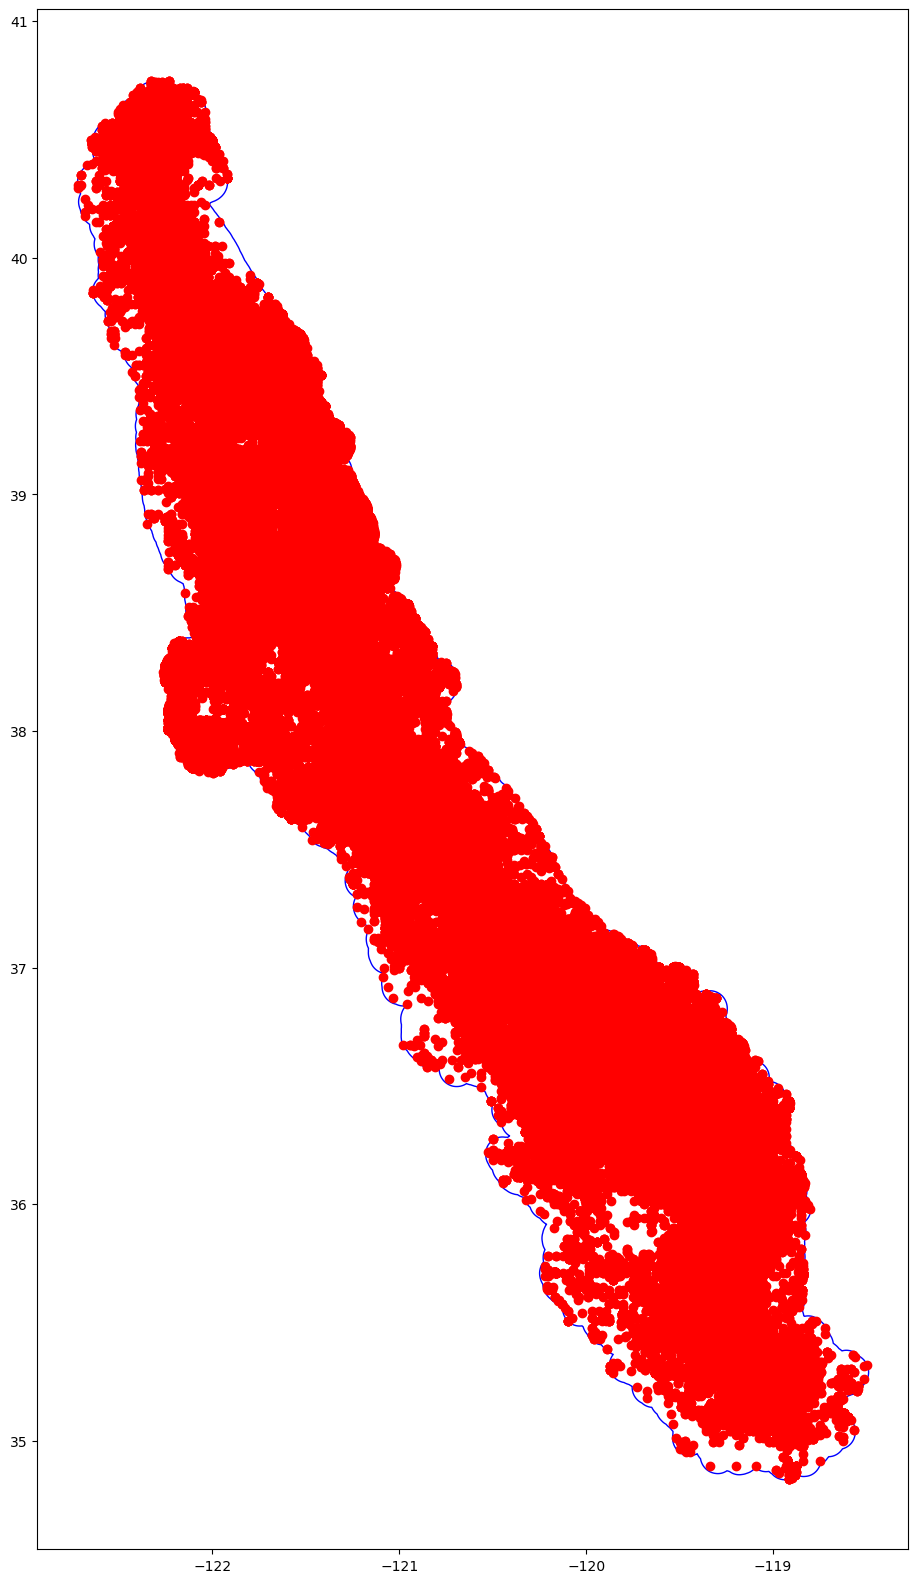

In [17]:
ax = aquifer_boundary.plot(figsize=(20, 20),color='white', edgecolor='blue')
# We can now plot our ``GeoDataFrame``.
klip.plot(figsize=(20, 20),ax=ax, color='red')
plt.show()

In [18]:
df2 = pd.DataFrame(klip, copy=True)

#join two table of water levels and stations

In [19]:
df2.to_csv('OSWCRgeospatial_central_valley.csv')

# export Clip's attribute tabe to csv file

In [20]:
# Vlookup lat-longs from original dataframe, since lattude and longitudes were rounded to the nearest
# 3 or 4 decimal places

In [21]:
# List of columns to drop
columns_to_drop = ['DECIMALLAT', 'DECIMALLON', 'Decimal_La', 'Decimal_Lo', 'geometry']

# Drop the columns from df2
df2 = df2.drop(columns=columns_to_drop)

# Display the modified dataframe
print(df2)

             WCRNUMBER
212631      WCR0021028
195721      WCR0050844
201530      WCR0151370
209164      WCR0124101
209087      WCR0289261
...                ...
815637  WCR1999-009057
822002  WCR2006-007563
811544  WCR2007-008886
819091  WCR2007-008885
818386  WCR2007-008884

[341535 rows x 1 columns]


In [22]:
print("DataFrame 1:\n", df1)
print("\nDataFrame 2:\n", df2)

DataFrame 1:
               WCRNUMBER DECIMALLATITUDE DECIMALLONGITUDE  Decimal_Latitude  \
0        WCR2005-016846         37.6724         -121.724         37.672400   
1        WCR2006-007057         37.5258          -122.03         37.525800   
5        WCR2022-006791         37.7705         -122.235         37.770500   
6        WCR2022-006853         37.7708         -122.236         37.770800   
7        WCR2022-009252         37.8632         -122.269         37.863200   
...                 ...             ...              ...               ...   
1077126  WCR2016-010959       38.833611      -121.254444         38.833611   
1077127  WCR2017-009515       37.338851      -120.448137         37.338851   
1077128  WCR2015-007327       38.044167      -121.236667         38.044167   
1077152  WCR2015-012485       38.179167      -121.070278         38.179167   
1077167  WCR2015-010692       37.768014       -121.30825         37.768014   

         Decimal_Longitude  
0              -121.

In [23]:
# Merging df1 into df2 on column 'WCRNUMBER'
result = pd.merge(df2, df1, on='WCRNUMBER', how='left')

print("\nMerged DataFrame:\n", result)


Merged DataFrame:
              WCRNUMBER DECIMALLATITUDE DECIMALLONGITUDE  Decimal_Latitude  \
0           WCR0021028         34.8399         -118.916           34.8399   
1           WCR0050844         34.8399         -118.916           34.8399   
2           WCR0151370         34.8399         -118.916           34.8399   
3           WCR0124101         34.8399         -118.916           34.8399   
4           WCR0289261         34.8399         -118.916           34.8399   
...                ...             ...              ...               ...   
341530  WCR1999-009057         40.7454         -122.327           40.7454   
341531  WCR2006-007563         40.7455         -122.232           40.7455   
341532  WCR2007-008886         40.7455         -122.232           40.7455   
341533  WCR2007-008885         40.7455         -122.232           40.7455   
341534  WCR2007-008884         40.7455         -122.232           40.7455   

        Decimal_Longitude  
0                -118.916  

In [24]:
result.to_csv('UPDATED_wellcompletionreports.csv')